<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Tensorboard_integration_Malaria_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt

In [52]:
dataset, dataset_info = tfds.load("malaria",
                                  with_info = True,
                                  as_supervised = True,
                                  shuffle_files = True,
                                  split = ["train"]
                                  )

In [53]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [54]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [6]:
dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
for data in dataset[0].take(1):
  print(data, len(data))

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>) 2


In [55]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [56]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

<b> Data Visualization </b>

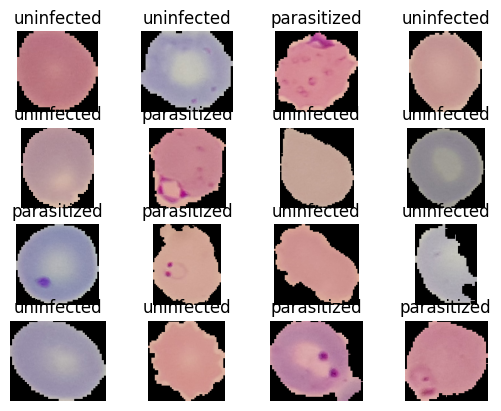

In [57]:
for i, (image, label) in enumerate(dataset[0].take(16)):
  ax = plt.subplot(4, 4, i+1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [11]:
dataset_info.features['label'].int2str(1)

'uninfected'

<h2> <b> Data Augmentation </b> </h2>

In [12]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

In [13]:
original_image, label = next(iter(train_dataset))

In [14]:
# augmenting an image
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor=0.1)

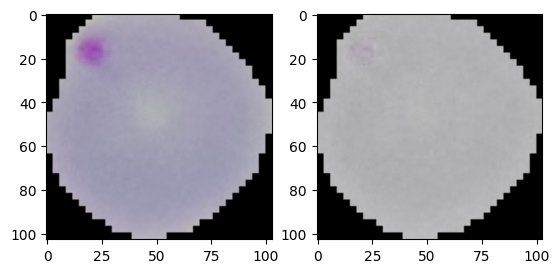

In [15]:
visualize(original_image, augmented_image)

In [16]:
IM_SIZE = 224

<b> resize, rescale images

In [17]:
@tf.function
def resize_rescale_func(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

<b> doing resize and rescale with tf.layer </b>

In [18]:
from tensorflow.keras.layers import Resizing, Rescaling

In [19]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1./255)
])

In [20]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast

In [21]:
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',),
       RandomContrast(factor=0.1),

])

In [22]:
def augment_layer_func(image_label, label):
  return augment_layers(resize_rescale_layers(image), training=True), label

<h2> <b> Data Loading </b> </h2>

In [23]:
BATCH_SIZE = 32

In [24]:
test_dataset = test_dataset.map(resize_rescale_func, num_parallel_calls = tf.data.AUTOTUNE)

In [25]:
train_dataset = (train_dataset.
                 shuffle(buffer_size = 1024, reshuffle_each_iteration = True).
                 map(augment_layer_func, num_parallel_calls = tf.data.AUTOTUNE).
                 batch(BATCH_SIZE).
                 prefetch(tf.data.AUTOTUNE)
                 )

In [26]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)
    .map(resize_rescale_func, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
)

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<h2> <b> Albumentations for data augmentation </b> </h2>

In [29]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-c8u7sc5x
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-c8u7sc5x
  Resolved https://github.com/albu/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


In [30]:
import albumentations as A

In [31]:
transforms = A.Compose(
    [
      A.Resize(IM_SIZE, IM_SIZE),

      A.OneOf([A.HorizontalFlip(),
                A.VerticalFlip(),], p = 0.3),

      A.RandomRotate90(),
      #A.RandomGridShuffle(grid=(3, 3), always_apply=False, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2,
                                always_apply=False, p=0.5),
      #A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
      A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5),
])

In [32]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255., tf.float32)
  return image

In [33]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

In [34]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [35]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [39]:
# these lines of code requires all of colab ram, and the program will crash

"""
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

plt.figure(figsize=(15,15))

for i in range(1,32):
  plt.subplot(8,4,i)
  plt.imshow(im[i])
"""
print("HAHAHA")

HAHAHA


<h2> <b> Repeating the dataset (x5) </b> </h2>

In [58]:
def augment_1(image, label):
  image, label = resize_rescale_func(image, label)

  image = tf.image.random_brightness(image, 0.2)
  return image, label

In [59]:
def augment_2(image, label):
  image, label = resize_rescale_func(image, label)

  image = tf.image.random_flip_up_down(image)
  return image, label

In [60]:
def augment_3(image, label):
  image, label = resize_rescale_func(image, label)

  image = tf.image.flip_left_right(image)
  return image, label

In [61]:
def augment_4(image, label):
  image, label = resize_rescale_func(image, label)

  image = tf.image.rot90(image)
  return image, label

In [62]:
def augment_5(image, label):
  image, label = resize_rescale_func(image, label)

  return image, label

In [63]:
train_dataset_1 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_1)
)

In [64]:
train_dataset_2 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_2)
)

In [65]:
train_dataset_3 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_3)
)

In [66]:
train_dataset_4 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_4)
)

In [67]:
train_dataset_5 = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(augment_5)
)

In [68]:
full_train_dataset = train_dataset_1.concatenate(train_dataset_2).concatenate(train_dataset_3).concatenate(train_dataset_4).concatenate(train_dataset_5)

In [70]:
full_train_dataset = (
    full_train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [72]:
full_train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>